# Meteorological Background Panel Plots

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import xarray as xr

import centered_response as cr
from wofunits import wofunits

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from metpy.plots import (ColdFront, WarmFront, StationaryFront, Dryline)

import warnings

warnings.filterwarnings("ignore")

    # set paths
wofs_path = wofunits.paths['wofs_path']
mrms_data_path = wofunits.paths['mrms_data_path']
outplot_path = wofunits.paths['outplot_path']

    # set list of case init times
cases = ['201905172200','201905202030','201905262000','201905282230']

    # set plotting bounds for each case (panel layout very sensitive to this)
latlon_bounds = {'201905172200': [-101.7, -99.2, 39.7, 41.6],
                 '201905202030': [-100.6, -98.1, 33.65, 35.55],
                 '201905262000': [-104.2, -102.05, 37.15, 38.7],
                 '201905282230': [-99.0, -96.5, 38.9, 40.7]}

# save figure?
save = True

# set colors for 3 plotted valid times
colors=['limegreen', 'royalblue', 'r']

# set axis labels
axlabels=['a) 17 May', 'b) 20 May', 'c) 26 May', 'd) 28 May']

# define confidence ellipse function
def confidence_ellipse(x,y, stdevs=2.0):
    cov = np.cov(x,y)
    val, rot = np.linalg.eig(cov)
    val = np.sqrt(val)
    center = np.mean([x, y], axis=1)[:, None]
    
    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)
    
    ellipse = (stdevs * rot @ (val * xy).T + center)
    
    return ellipse

## Set coordinate lists to draw fronts and low pressure centers

In [2]:
# Set and format coordinate lists for weather features

dl517_lat = [40.8, 40.5, 40.1, 39.5, 39.0, 38.5]
dl517_lon = [-102, -101.8, -101.6, -101.5, -101.1, -100.9]
wf517_lat = [41, 41.1, 41.25, 41.5, 41.9, 42.15, 42.4]
wf517_lon = [-102, -101.5, -101.0, -100.5, -100.0, -99.5, -99.0]

cf520_lat = [35, 35, 35.075, 35.1, 35.15, 35.3, 35.55, 35.8, 36.15, 36.3]
cf520_lon = [-101.5, -101, -100.5, -100, -99.5, -99, -98.5, -98, -97.5, -97]
cf520_lat.reverse()
cf520_lon.reverse()

low526 = (-104.2, 37.88)
wf526_lat = [38, 37.85, 37.8, 37.8, 37.85, 37.95, 38.05, 38.28, 38.75, 39.5]
wf526_lon = [-104, -103.75, -103.5, -103.25, -103, -102.75, -102.5, -102, -101.5, -101]
dl526_lat = [37.85, 37.7, 37.5, 37.0]
dl526_lon = [-103.7, -103.65, -103.65, -103.85]
trough526_lat = [37.95, 37.8, 37.7]
trough526_lon = [-104.2, -104.6, -104.9]

low528 = (-98.45, 39.45)
cf528_lat = [39.42, 39.325, 39.25, 39.125, 39.075, 38.975-0.2, 38.95-0.4]
cf528_lon = [-98.32, -98.325, -98.35, -98.425, -98.5, -99.8+0.02, -100.1]
wf528_lat = [39.6, 39.7, 39.8, 39.85, 39.85, 39.8, 39.7]
wf528_lon = [-98.2, -98, -97.8, -97.5, -97, -96.5, -96]



## Plot Fig. 3: Meteorological Background for Analyzed Cases

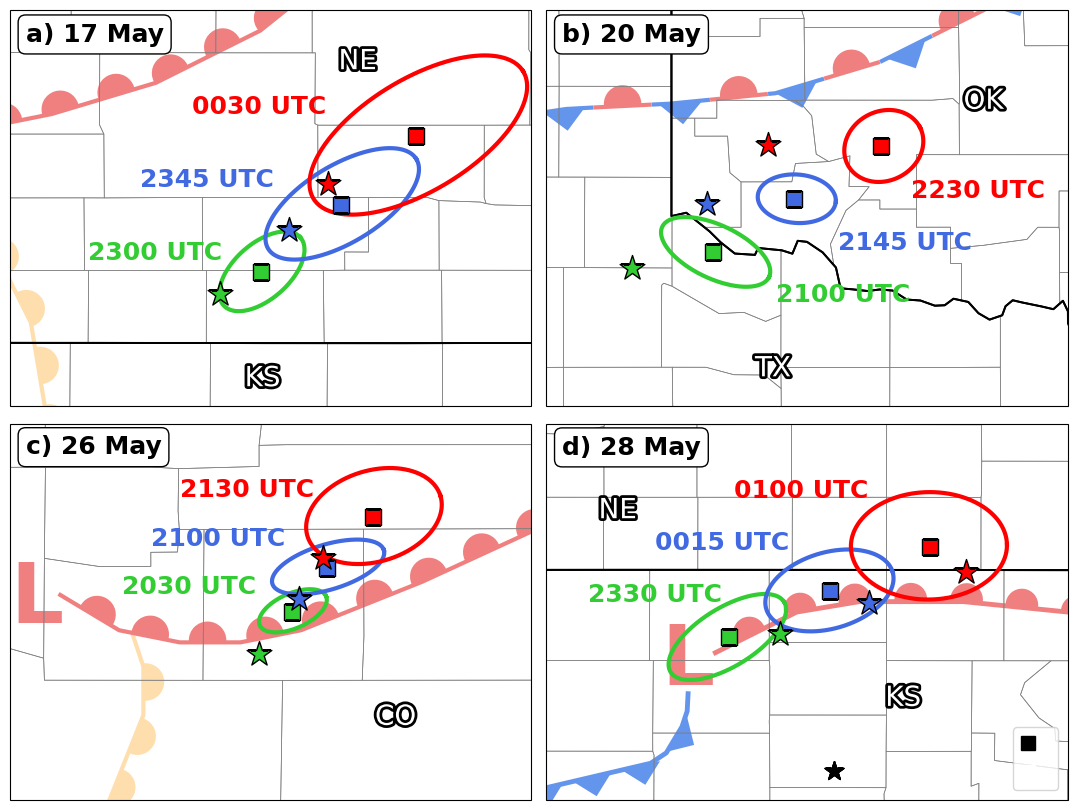

In [3]:
# Plot all member storm tracks

# Define figure
fig, ax = plt.subplots(
    nrows=2, ncols=2,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(11, 8.5)
)

# Turn 2D array of axes into 1D
ax = ax.flatten()

# Define mapping specs
shapefiles = wofunits.mapping['shapefiles']
edgecolor = wofunits.mapping['edgecolor']
lw = wofunits.mapping['lw']

for i, case in enumerate(cases):

    # Define case specs
    wofs_casedir, file_latlons, file_coords, file_resp_coords, \
    file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

    df_members = cr.create_coords_df(file_coords, file_mrms_maxima)

    # Pull lat/lons from MRMS file
    ds_mrms = xr.open_dataset(
        f'{mrms_data_path}/MRMS_{case[:8]}/'
        f'wofs_MRMS_RAD_{case[:8]}_{case[8:]}.nc'
    )
    lat = ds_mrms['lat'].values
    lon = ds_mrms['lon'].values

    # =========================
    # 17 May 2019
    # =========================
    if i == 0:

        ax[i].plot(dl517_lon, dl517_lat, lw=3,
                   path_effects=[Dryline(filled=True, color='navajowhite',
                                          size=12, spacing=1.5)],
                   zorder=0)

        ax[i].plot(wf517_lon, wf517_lat, lw=3, alpha=0.6,
                   path_effects=[WarmFront(color='lightcoral',
                                           size=12, spacing=1.5)],
                   zorder=0)

        idxs = [6, 12, 18]
        times = ['172300', '172345', '180030']

        for j in range(3):

            ds = xr.open_dataset(
                f'{wofs_path}/wofs_20190517_2200/'
                f'wofs_i{case}_v201905{times[j]}.nc'
            )

            # WoFS mean position
            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='s', s=130, edgecolor='k', zorder=3
            )

            # MRMS position
            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='*', s=350, edgecolor='k', zorder=3
            )

            ellipse = confidence_ellipse(
                lon[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values],
                lat[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values]
            )

            ax[i].plot(*ellipse, c=colors[j], lw=3,
                       transform=ccrs.PlateCarree(), zorder=2)

        # Time labels
        ax[i].text(-101.325, 40.4, '2300 UTC', weight='bold',
                   size=18, c=colors[0], transform=ccrs.PlateCarree())
        ax[i].text(-101.075, 40.75, '2345 UTC', weight='bold',
                   size=18, c=colors[1], transform=ccrs.PlateCarree())
        ax[i].text(-100.825, 41.1, '0030 UTC', weight='bold',
                   size=18, c=colors[2], transform=ccrs.PlateCarree())

        # State labels
        ax[i].text(0.45, 0.05, 'KS', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax[i].text(0.63, 0.85, 'NE', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])

    # =========================
    # 20 May 2019
    # =========================
    if i == 1:

        idxs = [2, 8, 14]
        times = ['202100', '202145', '202230']

        for j in range(3):

            ds = xr.open_dataset(
                f'{wofs_path}/wofs_20190520_2030/'
                f'wofs_i{case}_v201905{times[j]}.nc'
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='s', s=130, edgecolor='k', zorder=3
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='*', s=350, edgecolor='k', zorder=3
            )

            ellipse = confidence_ellipse(
                lon[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values],
                lat[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values]
            )

            ax[i].plot(*ellipse, c=colors[j], lw=3,
                       transform=ccrs.PlateCarree(), zorder=2)

        ax[i].plot(cf520_lon, cf520_lat, lw=3, alpha=0.6,
                   path_effects=[StationaryFront(
                       colors=('lightcoral', 'cornflowerblue'),
                       size=12, spacing=1.5)],
                   zorder=0)

        ax[i].text(-99.5, 34.15, '2100 UTC', weight='bold',
                   size=18, c=colors[0], transform=ccrs.PlateCarree())
        ax[i].text(-99.2, 34.4, '2145 UTC', weight='bold',
                   size=18, c=colors[1], transform=ccrs.PlateCarree())
        ax[i].text(-98.85, 34.65, '2230 UTC', weight='bold',
                   size=18, c=colors[2], transform=ccrs.PlateCarree())

        ax[i].text(0.4, 0.075, 'TX', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax[i].text(0.8, 0.75, 'OK', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])

    # =========================
    # 26 May 2019
    # =========================
    if i == 2:

        ax[i].plot(dl526_lon, dl526_lat, lw=3, alpha=0.6,
                   path_effects=[Dryline(filled=True, color='navajowhite',
                                          size=12, spacing=1.3)],
                   zorder=0)

        ax[i].plot(wf526_lon, wf526_lat, lw=3, alpha=0.6,
                   path_effects=[WarmFront(color='lightcoral',
                                           size=12, spacing=1.5)],
                   zorder=0)

        ax[i].text(low526[0], low526[1], 'L',
                   size=60, weight='bold', c='lightcoral',
                   transform=ccrs.PlateCarree(), zorder=0)

        idxs = [2, 6, 10]
        times = ['262030', '262100', '262130']

        for j in range(3):

            ds = xr.open_dataset(
                f'{wofs_path}/wofs_20190526_2000/'
                f'wofs_i{case}_v201905{times[j]}.nc'
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='s', s=130, edgecolor='k', zorder=3
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='*', s=350, edgecolor='k', zorder=3
            )

            ellipse = confidence_ellipse(
                lon[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values],
                lat[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values]
            )

            ax[i].plot(*ellipse, c=colors[j], lw=3,
                       transform=ccrs.PlateCarree(), zorder=2)

        ax[i].text(-103.74, 38.0, '2030 UTC', weight='bold',
                   size=18, c=colors[0], transform=ccrs.PlateCarree())
        ax[i].text(-103.62, 38.2, '2100 UTC', weight='bold',
                   size=18, c=colors[1], transform=ccrs.PlateCarree())
        ax[i].text(-103.50, 38.4, '2130 UTC', weight='bold',
                   size=18, c=colors[2], transform=ccrs.PlateCarree())

        ax[i].text(0.7, 0.2, 'CO', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])

    # =========================
    # 28 May 2019
    # =========================
    if i == 3:

        ax[i].plot(cf528_lon, cf528_lat, lw=3.5, alpha=0.6,
                   path_effects=[ColdFront(color='cornflowerblue',
                                            size=10, spacing=1.6)],
                   zorder=0)

        ax[i].plot(wf528_lon, wf528_lat, lw=3.5, alpha=0.6,
                   path_effects=[WarmFront(color='lightcoral',
                                           size=10, spacing=2)],
                   zorder=0)

        ax[i].text(low528[0], low528[1], 'L',
                   size=60, weight='bold', c='lightcoral',
                   transform=ccrs.PlateCarree(), zorder=0)

        idxs = [6, 12, 18]
        times = ['282330', '290015', '290100']

        for j in range(3):

            ds = xr.open_dataset(
                f'{wofs_path}/wofs_20190528_2230/'
                f'wofs_i{case}_v201905{times[j]}.nc'
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[:, idxs[j]].values,
                        df_members.iloc[:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='s', s=130, edgecolor='k', zorder=3
            )

            ax[i].scatter(
                np.mean(
                    lon[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                np.mean(
                    lat[df_members.iloc[-1:, idxs[j]].values,
                        df_members.iloc[-1:, idxs[j] + 1].values],
                    axis=0
                ),
                c=colors[j], transform=ccrs.PlateCarree(),
                marker='*', s=350, edgecolor='k', zorder=3
            )

            ellipse = confidence_ellipse(
                lon[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values],
                lat[df_members.iloc[:-1, idxs[j]].values,
                    df_members.iloc[:-1, idxs[j] + 1].values]
            )

            ax[i].plot(*ellipse, c=colors[j], lw=3,
                       transform=ccrs.PlateCarree(), zorder=2)

        ax[i].text(-98.8, 39.85, '2330 UTC', weight='bold',
                   size=18, c=colors[0], transform=ccrs.PlateCarree())
        ax[i].text(-98.48, 40.1, '0015 UTC', weight='bold',
                   size=18, c=colors[1], transform=ccrs.PlateCarree())
        ax[i].text(-98.1, 40.35, '0100 UTC', weight='bold',
                   size=18, c=colors[2], transform=ccrs.PlateCarree())

        ax[i].text(0.65, 0.25, 'KS', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax[i].text(0.1, 0.75, 'NE', transform=ax[i].transAxes,
                   size=20, color='w',
                   path_effects=[pe.withStroke(linewidth=4, foreground='k')])

    # =========================
    # COMMON MAP FEATURES
    # =========================
    for j in range(len(shapefiles)):
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries())
        feature = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax[i].add_feature(feature, facecolor='none',
                          edgecolor=edgecolor[j], lw=lw[j], zorder=1)

    ax[i].set_extent(latlon_bounds[case], crs=ccrs.PlateCarree())

    ax[i].annotate(axlabels[i], xy=(0.03, 0.92),
                   bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'),
                   size=18, weight='bold',
                   xycoords='axes fraction')

    ksquare = mpatches.Rectangle((0, 0), 1, 1, color='k')
    wsquare = mpatches.Rectangle((0, 0), 1, 1, color='w')

    plt.legend(['WoFS Mean Position', 'Observed Position'],
               handles=[ksquare, wsquare],
               fontsize=14, handlelength=0.7,
               loc='lower right')

    ax[3].scatter(-97.62, 39.04, marker='*', c='k', s=200, zorder=1002)

plt.subplots_adjust(hspace=0, wspace=0.1)
plt.tight_layout()

if save:
    plt.savefig( f'{outplot_path}/met_overview_meanref.png',dpi=300, bbox_inches='tight', facecolor='w')
